In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import json
import torch
import cv2

from tqdm import tqdm
from skimage.color import rgb2lab, lab2rgb
from typing import List, Dict, Tuple
from numba import njit
from scipy.ndimage import center_of_mass
from skimage import draw

from src.utils import *
from src.refine_transform import *
from src.find_transform import *
from src.shape_align import new_pairwise_alignment

In [6]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [7]:
frag1 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200)
frag2 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200)

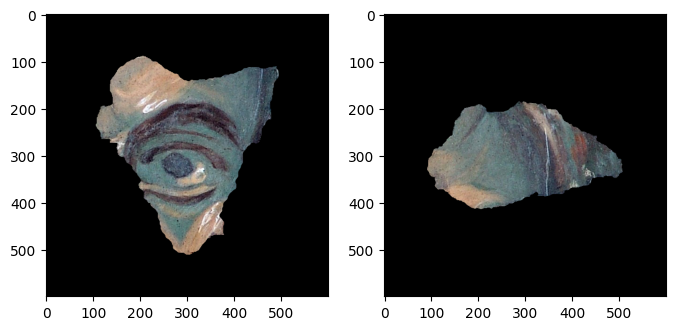

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [12]:
# load dict from json
# refined_alignment = json.load(open("probs_merged.json", "r"))
refined_alignment = json.load(open("alignments/alignments1.json", "r"))

In [13]:
# parsing frag ids from json
ids = [int(k.split("_")[0]) for k in refined_alignment.keys()]
ids.extend([int(k.split("_")[1]) for k in refined_alignment.keys()])
ids = sorted(list(set(ids)))
print(ids)
frag_numbers = ids
map_id_to_idx = {frag_numbers[i]: i for i in range(len(frag_numbers))}
pad_size = 220
frags = [pad_fragment_to_size(build_fragment_from_directory(data_dir + '/' + str(num)), pad_size) for num in frag_numbers]

[3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]


In [14]:
def json_based_to_idx_translation_dict(
    json_based: Dict[str, List],
    id_to_idx: Dict[int, int], 
    frag_numbers: List[int]) -> Dict[Tuple[int, int], List[Translation]]:
    res = {}
    for k, v in tqdm(json_based.items()):
        key = (id_to_idx[int(k.split("_")[0])], id_to_idx[int(k.split("_")[1])])
        res[key] = [Translation(*val.values()) for val in v]
    return res
    

In [15]:
refined_alignment = json_based_to_idx_translation_dict(refined_alignment, map_id_to_idx, frag_numbers)

100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 62230.03it/s]


# Watching results of previous stages

In [18]:
from src.reestimating import *
from src.visualize import *

In [19]:
print([(fr_num, i) for i, fr_num in enumerate(frag_numbers)])

[(3, 0), (5, 1), (6, 2), (7, 3), (8, 4), (9, 5), (10, 6), (11, 7), (12, 8), (14, 9), (15, 10)]


In [21]:
def rotate_fragment(frag, angle, c=None):
    """
    fast rotate
    """
    # TODO: rotate edge_coords
    h, w = frag.fragment.shape[:2]
    if c is None:
        c = (w // 2, h // 2)
    m = cv2.getRotationMatrix2D(center=c, angle=angle, scale=1.0)
    fr = Fragment(
        cv2.warpAffine(frag.fragment, M=m, dsize=(w, h)),
        cv2.warpAffine(frag.extended_frag, M=m, dsize=(w, h)),
        cv2.warpAffine(frag.mask * 255.0, M=m, dsize=(w, h)) == 255,
        cv2.warpAffine(frag.extended_mask * 255.0, M=m, dsize=(w, h)) == 255
    )
    if fr.fragment.max() > 1:
        fr.fragment = fr.fragment / 255.0
    if fr.extended_frag.max() > 1:
        fr.extended_frag = fr.extended_frag / 255.0
    return fr

Confidence = 0.9074293917197327, translation = Translation(x=196, y=-22, angle=-3.9918749945944967, confidence=0.9074293917197327, geom_score=0.9427616176107795)


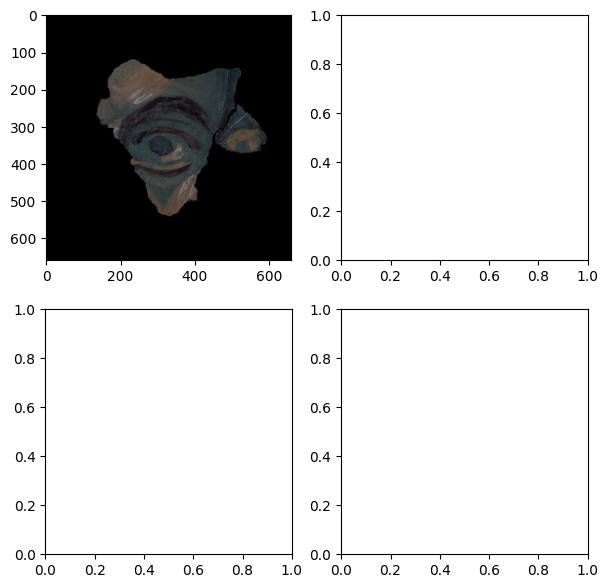

In [35]:
l, r = 1, 5

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
for i in range(len(refined_alignment[(l, r)][:4])):
    tr = refined_alignment[(l, r)][i]
    transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
    blended = blend_fragments(frags[r], transformed)
    
    axes[i // 2][i % 2].imshow(blended.fragment)
#     print(rotate_fragment(pad_fragment_to_size(frags[l], 200), 0).fragment.max())
#     axes[i // 2][i % 2].imshow(pad_fragment_to_size(frags[l], 200).fragment)
    
    print(f"Confidence = {tr.confidence}, translation = {tr}")


# Reestimating

In [25]:
print(frag_numbers)

[3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]


In [36]:
anchor_i, second_i, third_i = 5, 1, 2
anchor = frags[anchor_i]
second = frags[second_i]
third = frags[third_i]
transform1 = refined_alignment[(anchor_i, second_i) if anchor_i < second_i else (second_i, anchor_i)][0]
transform2 = refined_alignment[(anchor_i, third_i) if anchor_i < third_i else (third_i, anchor_i)][1]

In [37]:

def estimate_triplet(
    anchor: Fragment,
    second: Fragment,
    third: Fragment, 
    transform1: Translation, 
    transform2: Translation,
    transpose1: bool = False,
    transpose2: bool = False,
    verbose: int = 1
):
    """
    anchor: acnhor fragment 
    second: non-shifted neihgbor
    third: non-shifted neighbor, which is used to estimate pair (anchor, second), third neighbor
    transform1: Translation, transform to be used to align second 
    transform2: Translation, transform to be used to align third
    
    return: bool, is the triplet good
    """
#     print("Checking if too far or intersects too much")
    tr1 = transform_fragment(second, transform1, transpose1)
    tr2 = transform_fragment(third, transform2, transpose2)
    if check_if_two_fragments_are_too_far(tr1, tr2):
        return False
    if check_if_fragments_intersect_too_much(tr1, tr2):
        return False
    
    transf1_neighbourhood = generate_transform_neighborhood(transform1)
    transf2_neighbourhood = generate_transform_neighborhood(transform2)
    
    # iterate over neighborhood
    print("creating neighbor fragments...")
    transformed1_lst = [transform_fragment(second, tr1, transpose=transpose1) for tr1 in (tqdm(transf1_neighbourhood) if verbose else transf1_neighbourhood)]
    transformed2_lst = [transform_fragment(third, tr2, transpose=transpose2) for tr2 in transf2_neighbourhood]
    print("iterating over neighbor fragments...")
    for transformed1 in tqdm(transformed1_lst) if verbose else transformed1_lst:
        for transformed2 in transformed2_lst:
            common_ext_intersection_exists = check_common_ext_intersection(anchor, transformed1, transformed2)
            if not common_ext_intersection_exists:
                continue
            common_intersection_exists = check_common_intersection(anchor, transformed1, transformed2)
            if common_intersection_exists:
                continue
            geom_score1_2 = compute_geom_morph_score(anchor, transformed1)
            geom_score1_3 = compute_geom_morph_score(anchor, transformed2)
            geom_score2_3 = compute_geom_morph_score(transformed1, transformed2)
            # print(geom_score1_2, geom_score1_3, geom_score2_3)
            if geom_score1_2 > 0.6 and geom_score2_3 > 0.6 and geom_score1_3 > 0.6:
                return (transformed1, transformed2)
    return False

def compute_geom_morph_score(frag1, frag2, structure_elem=np.ones((25, 25))):
    """
    params:
    frag1, frag2: two fragments to check
    structure_elem: morphological structuring element for morphological closing
    suitable geometric score for reestimating: 1 - gap / extended intersection
    """
    two_mask = np.logical_or(frag1.mask, frag2.mask)
    wide_intersection = np.logical_and(frag1.extended_mask, frag2.extended_mask)
    merged = cv2.morphologyEx(two_mask * 1.0, cv2.MORPH_CLOSE, structure_elem, iterations=1)
    wide_union = np.logical_or(frag1.extended_mask, frag2.extended_mask)
    
    if len(wide_union.shape) == 2:
        wide_union = wide_union[:,:,None]
    if len(wide_intersection.shape) == 2:
        wide_intersection = wide_intersection[:,:,None]
    if len(two_mask.shape) == 2:
        two_mask = two_mask[:,:,None]
        
    # gap = np.logical_and(
    #     wide_intersection,
    #     np.logical_and(
    #         merged[:,:,None],
    #         np.logical_not(two_mask)
    #     )
    # )
    gap = wide_intersection & merged[:,:,None].astype(bool) & np.logical_not(two_mask)
    gap_sum, intersection_sum = gap.sum(), wide_intersection.sum()
    return 1 - gap_sum / intersection_sum

In [38]:
res = estimate_triplet(anchor, second, third, transform1, transform2, transpose1=anchor_i<second_i, transpose2=anchor_i<third_i, verbose=1)

creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 37.20it/s]


iterating over neighbor fragments...


 46%|██████████████████████████████████████                                            | 58/125 [00:03<00:03, 19.16it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Good triplet! Found good frag positions


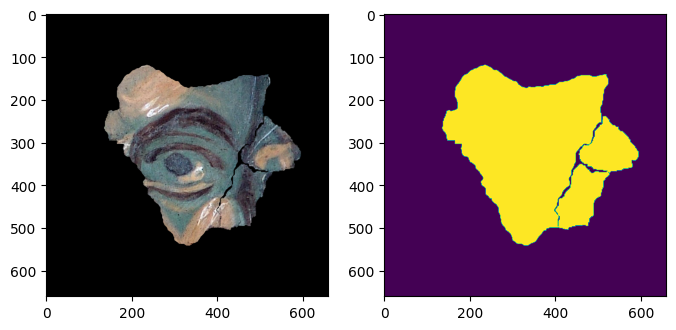

In [41]:
if res != False:
    print("Good triplet! Found good frag positions")
    visualize_triplet(anchor, res[0], res[1])
else:
    print("Bad triplet!")

## End of debugged code

## In progress: analyzing all possible triplets

In [42]:
print([(i, frag_numbers[i]) for i in range(len(frag_numbers))])

[(0, 3), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 10), (7, 11), (8, 12), (9, 14), (10, 15)]


In [ ]:
idx1 = 5
idx2 = 6
idx3 = 9
second_i, third_i, anchor_i = sorted([idx2, idx3, idx1])

anchor = frags[anchor_i]
second = frags[second_i]
third = frags[third_i]

matches = []
for tr1 in refined_alignment[(anchor_i, second_i) if anchor_i < second_i else (second_i, anchor_i)]:
    for tr2 in refined_alignment[(anchor_i, third_i) if anchor_i < third_i else (third_i, anchor_i)]:
        res = estimate_triplet(anchor, second, third, tr1, tr2, transpose1=anchor_i<second_i, transpose2=anchor_i<third_i, verbose=1)
        matches.append(res)



In [44]:
if not res:
    print("Triplet has not been found")
else:
    print("Triplet has been found")

Triplet has not been found


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


geom_scores = (0.8025343189017952, 0.8444326052210975, 0.7854691075514875)


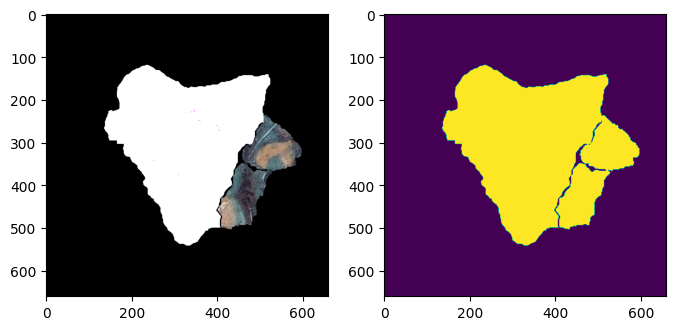

In [28]:
anchor, transformed1, transformed2 = res[0], res[3], res[4]
transpose1, transpose2 = res[5], res[6]


geom_score1_2 = compute_geom_morph_score(anchor, transformed1)
geom_score1_3 = compute_geom_morph_score(anchor, transformed2)
geom_score2_3 = compute_geom_morph_score(transformed1, transformed2)
print(f"geom_scores = {geom_score1_2, geom_score1_3, geom_score2_3}")

visualize_triplet(anchor, transformed1, transformed2)

geom_scores = (0.571825121443442, 0.4389555398729711, 0.5258215962441315)


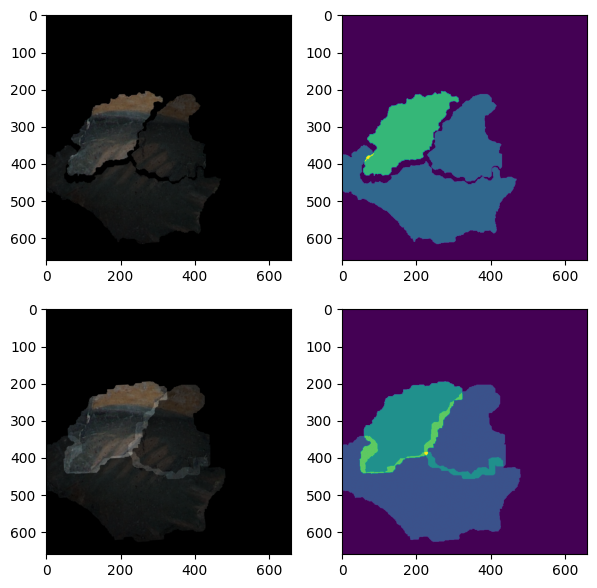

In [19]:
# transform1 = refined_alignment[(anchor_i, second_i) if anchor_i < second_i else (second_i, anchor_i)][0]
# transform2 = refined_alignment[(anchor_i, third_i) if anchor_i < third_idx else (third_idx, anchor_i)][0]
# print(l, r)
# if l > r:
#     transform1 = Translation(- transform1.x, - transform1.y, - transform1.angle, transform1.confidence, transform1.geom_score)

# anchor = res[0]
# second = res[1]
# third = res[2]
# transform1 = res[3]
# transform2 = res[4]
# transpose1 = res[5]
# transpose2 = res[6]

# l, r, third = 
i1, i2, i3 = 15, 14, 16
anchor = frags[i1]
second = frags[i2]
third = frags[i3]
transform1 = refined_alignment[(i2, i1) if i2 < i1 else (i1, i2)][0]
transform2 = refined_alignment[(i3, i1) if i3 < i1 else (i1, i3)][0]
transpose1 = i1 < i2
transpose2 = i1 < i3

# if l < r:
#     transformed = rotate_fragment(pad_fragment_to_size(second, 200), transform1.angle)
#     transformed = shift_fragment(transformed, transform1.x, transform1.y)
# else: # if l > r, first shift, then rotate
#     transformed = shift_fragment(pad_fragment_to_size(second, 200), transform1.x, transform1.y)
#     transformed = rotate_fragment(transformed, transform1.angle)
# transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(second, 200), transform1.angle), transform1.x, transform1.y)

transformed2 = transform_fragment(second, Translation(transform1.x, transform1.y, transform1.angle, transform1.confidence, transform1.geom_score), transpose=transpose1)
transformed3 = transform_fragment(third, Translation(transform2.x, transform2.y, transform2.angle, transform2.confidence, transform2.geom_score), transpose=transpose2)

# transformed2 = res[3]
# transformed3 = res[4]
# transformed
# print(f"is possible = {check_possibility_of_triplet(anchor, transformed2, transformed3)}")
visualize_fragment(blend_fragments(blend_fragments(anchor, transformed2), transformed3))
geom_score1_2 = compute_geom_morph_score(anchor, transformed2)
geom_score1_3 = compute_geom_morph_score(anchor, transformed3)
geom_score2_3 = compute_geom_morph_score(transformed2, transformed3)
print(f"geom_scores = {geom_score1_2, geom_score1_3, geom_score2_3}")